In [7]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import requests
import random
import logging
import time
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu, chi2_contingency
import os
import io

DATA_DIR_RAW = os.path.join("..", "..", "data", "raw")
DATA_DIR_PROCESSED = os.path.join("..", "..", "data", "processed")

# 🪵 Logging setup
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

In [13]:
import matplotlib.font_manager as fm

available_fonts = sorted({f.name for f in fm.fontManager.ttflist})
plt.rcParams['font.family'] = 'Garamond'
plt.rcParams['font.size'] = 14

In [14]:
OUTPUT_ACE_CBD_2024 = os.path.join(DATA_DIR_RAW, "ACE_CBD_exempt_violations_2024.csv")
ACE_CBD_exempt_violations_2024 = pd.read_csv(OUTPUT_ACE_CBD_2024)
ACE_CBD_exempt_violations_2024.head()

,violation_id,vehicle_id,first_occurrence,last_occurrence,violation_status,violation_type,bus_route_id,violation_latitude,violation_longitude,stop_id,stop_name,bus_stop_latitude,bus_stop_longitude,violation_georeference,bus_stop_georeference,route_id
0,452517324,3fbfaed0785d8e5a1c9ecc32b7e493e6ae07261ba9115e...,2024-12-31 10:54:43,2024-12-31T11:08:23.000,EXEMPT - COMMERCIAL UNDER 20,MOBILE DOUBLE PARKED,M101,40.832263,-73.942474,402526,AMSTERDAM AV/W 155 ST,40.831683,-73.942827,POINT (-73.942474 40.832263),POINT (-73.942827 40.831683),M101
1,452517306,ef6afb15ef2f996ef24568513e60cc25a1eb72d0b7c525...,2024-12-31 08:31:27,2024-12-31T08:35:31.000,EXEMPT - COMMERCIAL UNDER 20,MOBILE DOUBLE PARKED,M101,40.795071,-73.942076,402677,3 AV/E 37 ST,40.747988,-73.976370,POINT (-73.942076 40.795071),POINT (-73.97637 40.747988),M101
2,452517258,df1f37b3d595dc65291f25196d9e957b006e9472660bbb...,2024-12-31 15:59:11,2024-12-31T16:48:22.000,EXEMPT - EMERGENCY VEHICLE,MOBILE DOUBLE PARKED,M101,40.842348,-73.935127,402740,AMSTERDAM AV/W 171 ST,40.841978,-73.935267,POINT (-73.935127 40.842348),POINT (-73.935267 40.841978),M101
3,452517238,df1f37b3d595dc65291f25196d9e957b006e9472660bbb...,2024-12-31 15:59:11,2024-12-31T16:11:37.000,EXEMPT - EMERGENCY VEHICLE,MOBILE DOUBLE PARKED,M101,40.842344,-73.935110,402740,AMSTERDAM AV/W 171 ST,40.841978,-73.935267,POINT (-73.93511 40.842344),POINT (-73.935267 40.841978),M101
4,452461536,3f4f9c3891611af34c2290a19eb7c2b7cc62f8c66bbefd...,2024-12-31 10:04:58,2024-12-31T10:32:05.000,EXEMPT - EMERGENCY VEHICLE,MOBILE DOUBLE PARKED,M101,40.842417,-73.935064,402740,AMSTERDAM AV/W 171 ST,40.841978,-73.935267,POINT (-73.935064 40.842417),POINT (-73.935267 40.841978),M101


In [15]:
OUTPUT_events = os.path.join(DATA_DIR_RAW, "events_manhattan_2024.csv")
events_manhattan_2024 = pd.read_csv(OUTPUT_events)
events_manhattan_2024.head()

event_types = [
    "Block Party",
    "Athletic",
    "Athletic Race / Tour",
    "Street Event",
    "Shooting Permit",
    "Sport-Youth"
]

events_manhattan_2024 = events_manhattan_2024[
    (events_manhattan_2024["event_type"].isin(event_types)) |
    (events_manhattan_2024["street_closure_type"].notna())
]

print(f"Number of filtered events: {len(events_manhattan_2024)}")
events_manhattan_2024


Number of filtered events: 69525


,event_id,event_name,start_date_time,end_date_time,event_agency,event_type,event_borough,event_location,event_street_side,street_closure_type,community_board,police_precinct
7,783041,Lower East Side Farmstand Friday,2024-09-20T08:00:00.000,2024-09-20T15:30:00.000,Street Activity Permit Office,Farmers Market,Manhattan,GRAND STREET between WILLETT STREET and PITT S...,North,Sidewalk and Curb Lane Closure,"3,","7,"
8,759245,HHFM Lenox Avenue Market,2024-09-21T08:00:00.000,2024-09-21T15:00:00.000,Street Activity Permit Office,Farmers Market,Manhattan,LENOX AVENUE between WEST 117 STREET and WEST...,West,Sidewalk and Curb Lane Closure,"10,","28,"
23,751978,St. Anthony Flea Market,2024-09-21T09:00:00.000,2024-09-21T19:00:00.000,Street Activity Permit Office,Sidewalk Sale,Manhattan,WEST HOUSTON STREET between THOMPSON STREET an...,West,Sidewalk and Curb Lane Closure,"2,","1, 6,"
52,702878,Street Health Outreach Wellness Program,2024-09-13T10:00:00.000,2024-09-13T18:00:00.000,Street Activity Permit Office,Street Event,Manhattan,AMSTERDAM AVENUE between WEST 180 STREET and ...,East,Curb Lane Only,"12,","34,"
63,785210,Broadway Rhythm,2024-09-25T11:00:00.000,2024-09-25T15:00:00.000,Street Activity Permit Office,Plaza Event,Manhattan,39/40 Broadway Pedestrian Plaza (Broadway Blvd...,Full,Pedestrian Plaza,"5,","14,"
...,...,...,...,...,...,...,...,...,...,...,...,...
1419263,823921,"Mobile X RAY, testing unit",2024-12-12T00:00:00.000,2025-01-12T23:30:00.000,Street Activity Permit Office,Street Event,Manhattan,EAST 45 STREET between VANDERBILT AVENUE and...,North,Partial Sidewalk Closure,"5,","14, 18,"
1419264,812652,Fifth Avenue Association Annual Holiday Decor ...,2024-11-21T10:00:00.000,2025-01-06T20:00:00.000,Street Activity Permit Office,Street Event,Manhattan,FIFTH AVENUE between EAST 47 STREET and EAST...,Both,Partial Sidewalk Closure,"5,","18,"
1419267,823921,"Mobile X RAY, testing unit",2024-12-13T00:00:00.000,2025-01-12T23:30:00.000,Street Activity Permit Office,Street Event,Manhattan,EAST 45 STREET between VANDERBILT AVENUE and...,North,Partial Sidewalk Closure,"5,","14, 18,"
1419268,818955,Holidays on Madison Holiday Shopping Displays,2024-11-26T10:00:00.000,2025-01-24T18:00:00.000,Street Activity Permit Office,Street Event,Manhattan,MADISON AVENUE between EAST 61 STREET and EA...,West,Partial Sidewalk Closure,"8,","19,"


### Insights

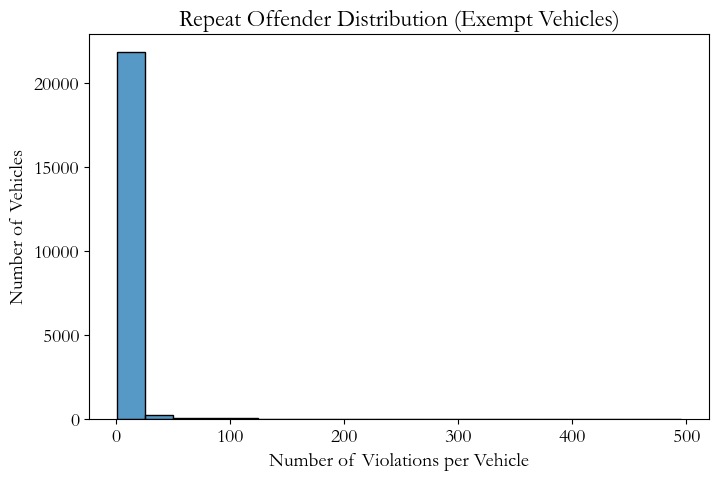

count    22232.000000
mean         3.394881
std         10.479276
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        495.000000
Name: violation_count, dtype: float64


In [16]:
# Q: Do exempt vehicles repeatedly commit violations?

repeat_offenders = ACE_CBD_exempt_violations_2024.groupby("vehicle_id")["violation_id"].count().reset_index(name="violation_count")

plt.figure(figsize=(8,5))
sns.histplot(repeat_offenders["violation_count"], bins=20, kde=False)
plt.xlabel("Number of Violations per Vehicle")
plt.ylabel("Number of Vehicles")
plt.title("Repeat Offender Distribution (Exempt Vehicles)")
plt.show()

print(repeat_offenders["violation_count"].describe())


Business insight:
- If a small % of vehicles account for most violations → some businesses abuse the exemption system.
- If most are 1-time offenders → exemptions might serve occasional, legitimate needs.

                   stop_name  violation_count
24              2 AV/E 23 ST             5628
271  MADISON ST/CATHERINE ST             3342
113    AMSTERDAM AV/W 175 ST             2226
8               1 AV/E 28 ST             2051
110    AMSTERDAM AV/W 171 ST             1748
31              2 AV/E 78 ST             1716
272      PEARL ST/BEEKMAN ST             1594
20             2 AV/E 106 ST             1560
22             2 AV/E 125 ST             1560
273       PEARL ST/FULTON ST             1440


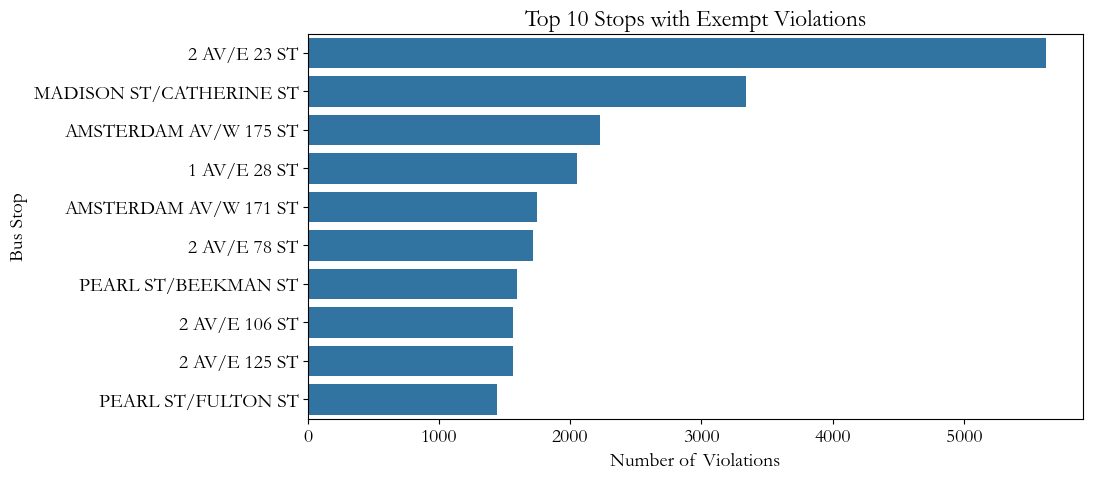

In [17]:
# Q: Where are exempt vehicles frequently in violation?

stop_hotspots = ACE_CBD_exempt_violations_2024.groupby("stop_name")["violation_id"].count().reset_index(name="violation_count")
stop_hotspots = stop_hotspots.sort_values("violation_count", ascending=False).head(10)
print(stop_hotspots)

plt.figure(figsize=(10,5))
sns.barplot(data=stop_hotspots, x="violation_count", y="stop_name")
plt.xlabel("Number of Violations")
plt.ylabel("Bus Stop")
plt.title("Top 10 Stops with Exempt Violations")
plt.show()


Business insight:
- These hotspots may be congestion points where business deliveries conflict with buses.
- City DOT can consider targeted policies: designated delivery zones or stricter monitoring.

In [18]:
# Q: Are some bus routes disproportionately impacted?

route_hotspots = ACE_CBD_exempt_violations_2024.groupby("bus_route_id")["violation_id"].count().reset_index(name="violation_count")
route_hotspots = route_hotspots.sort_values("violation_count", ascending=False)
print(route_hotspots.head(10))

  bus_route_id  violation_count
1         M15+            42037
0         M101            25607
3         M34+             5162
2         M23+             2670


Business insight:
- High-impact routes = high passenger volume routes being slowed by exempt vehicles.
- Can guide transit enforcement priorities.

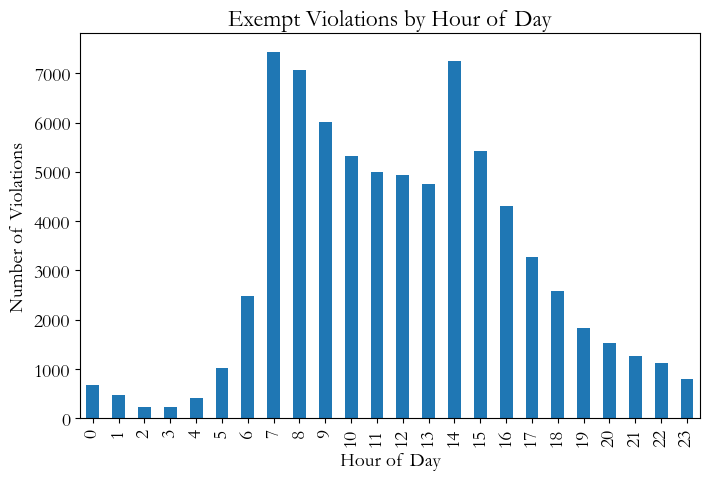

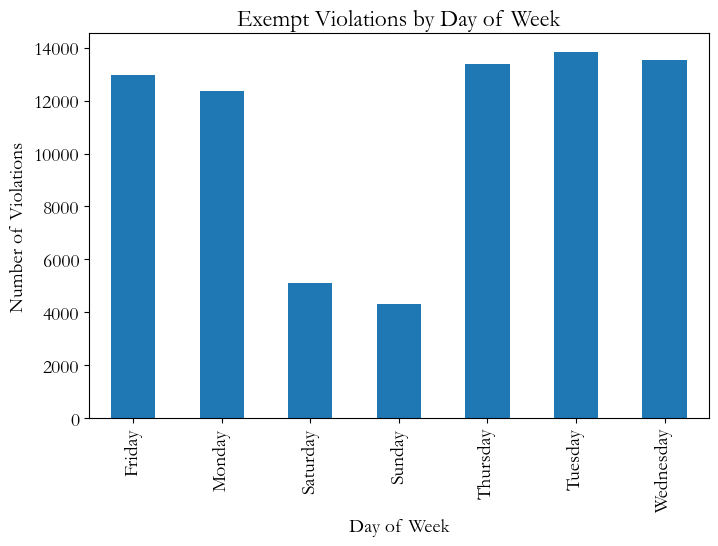

In [39]:
# Q: When do exempt violations occur most often?

ACE_CBD_exempt_violations_2024["first_occurrence"] = pd.to_datetime(ACE_CBD_exempt_violations_2024["first_occurrence"])

ACE_CBD_exempt_violations_2024["hour"] = ACE_CBD_exempt_violations_2024["first_occurrence"].dt.hour
hourly_counts = ACE_CBD_exempt_violations_2024.groupby("hour")["violation_id"].count()

plt.figure(figsize=(8,5))
hourly_counts.plot(kind="bar")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Violations")
plt.title("Exempt Violations by Hour of Day")
plt.show()

ACE_CBD_exempt_violations_2024["day_of_week"] = ACE_CBD_exempt_violations_2024["first_occurrence"].dt.day_name()
dow_counts = ACE_CBD_exempt_violations_2024.groupby("day_of_week")["violation_id"].count()

plt.figure(figsize=(8,5))
dow_counts.plot(kind="bar")
plt.xlabel("Day of Week")
plt.ylabel("Number of Violations")
plt.title("Exempt Violations by Day of Week")
plt.show()


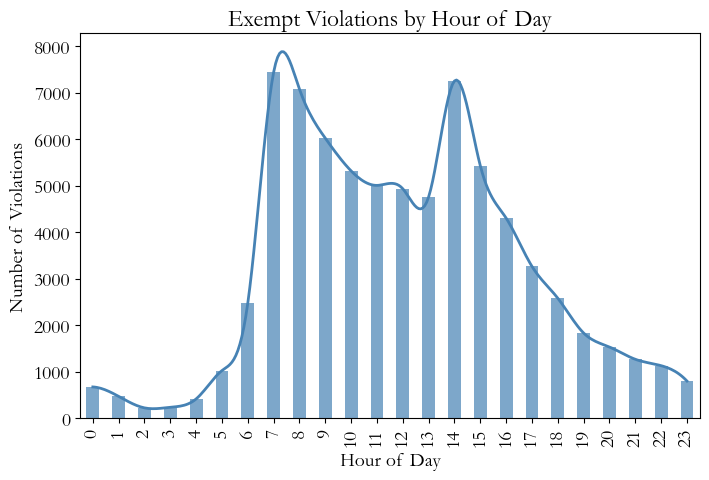

In [57]:
import numpy as np
from scipy.interpolate import make_interp_spline

# Q: When do exempt violations occur most often?

ACE_CBD_exempt_violations_2024["first_occurrence"] = pd.to_datetime(
    ACE_CBD_exempt_violations_2024["first_occurrence"]
)

ACE_CBD_exempt_violations_2024["hour"] = (
    ACE_CBD_exempt_violations_2024["first_occurrence"].dt.hour
)
hourly_counts = ACE_CBD_exempt_violations_2024.groupby("hour")["violation_id"].count()

plt.figure(figsize=(8,5))

# Bar chart
hourly_counts.plot(kind="bar", color="steelblue", alpha=0.7)

# Smooth line interpolation
x = hourly_counts.index.values
y = hourly_counts.values
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = make_interp_spline(x, y)(x_smooth)

plt.plot(x_smooth, y_smooth, color="steelblue", linewidth=2)

plt.xlabel("Hour of Day")
plt.ylabel("Number of Violations")
plt.title("Exempt Violations by Hour of Day")
plt.show()


### Statistical Tests

In [20]:
OUTPUT_ACE_NON_CBD_2024 = os.path.join(DATA_DIR_RAW, "ACE_CBD_non_exempt_violations_2024.csv")
ACE_CBD_non_exempt_violations_2024 = pd.read_csv(OUTPUT_ACE_NON_CBD_2024)
ACE_CBD_non_exempt_violations_2024.head()

,violation_id,vehicle_id,first_occurrence,last_occurrence,violation_status,violation_type,bus_route_id,violation_latitude,violation_longitude,stop_id,stop_name,bus_stop_latitude,bus_stop_longitude,violation_georeference,bus_stop_georeference,route_id
0,466434011,0793aa5cb07e4fe2f0b708322397596b572bb8bb20ce57...,2024-12-31 10:54:43,2025-04-10T10:41:54.000,VIOLATION ISSUED,MOBILE BUS STOP,M15+,40.800044,-73.932396,401727,1 AV/E 116 ST,40.796303,-73.935089,POINT (-73.932396 40.800044),POINT (-73.935089 40.796303),M15+
1,466433995,f6e5765ff6839c918516f8590ff7d16f4c0cd727a83b70...,2024-12-31 08:31:27,2025-04-10T10:41:12.000,VIOLATION ISSUED,MOBILE BUS STOP,M101,40.776321,-73.955804,403433,3 AV/E 79 ST,40.774605,-73.956970,POINT (-73.955804 40.776321),POINT (-73.95697 40.774605),M101
2,466433863,b3608c6757c16d1433d98cca64bf29a7eeacd874c61281...,2024-12-31 15:59:11,2025-04-10T10:22:13.000,VIOLATION ISSUED,MOBILE BUS STOP,M15+,40.711928,-73.998177,403601,PEARL ST/BEEKMAN ST,40.708264,-74.003099,POINT (-73.998177 40.711928),POINT (-74.003099 40.708264),M15+
3,466433834,c97d07bd6e7c1756a5160064e8fcf1ecd83f2d41edbb3c...,2024-12-31 15:59:11,2025-04-10T10:20:34.000,VIOLATION ISSUED,MOBILE BUS STOP,M34+,40.742672,-73.977489,401824,E 34 ST /PARK AV,40.746929,-73.981102,POINT (-73.977489 40.742672),POINT (-73.981102 40.746929),M34+
4,466418716,575ad6f7c9a7153641b82d41f83f446ea7c64398a299cb...,2024-12-31 10:04:58,2025-04-09T12:42:33.000,VIOLATION ISSUED,MOBILE BUS STOP,M15+,40.771039,-73.953578,401707,1 AV/E 67 ST,40.764870,-73.958109,POINT (-73.953578 40.771039),POINT (-73.958109 40.76487),M15+


In [21]:
# Q: Are exempt vehicles statistically more likely to be repeat offenders?

exempt_counts = ACE_CBD_exempt_violations_2024.groupby("vehicle_id")["violation_id"].count().reset_index(name="violation_count")
non_exempt_counts = ACE_CBD_non_exempt_violations_2024.groupby("vehicle_id")["violation_id"].count().reset_index(name="violation_count")

In [22]:
# Statistical test comparing two distributions that may not be normally distributed.
# Null hypothesis (H₀): The distributions of exempt vs. non-exempt violation counts are the same.
# If p < 0.05, you reject H₀ → meaning exempt vehicles’ violation counts are statistically different.

from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(exempt_counts["violation_count"], 
                       non_exempt_counts["violation_count"], 
                       alternative="two-sided")

print("Mann-Whitney U test statistic:", stat)
print("p-value:", p)

Mann-Whitney U test statistic: 697899458.0
p-value: 0.0


In [23]:
# Calculates the proportion of vehicles that are repeat offenders (more than 1 violation)

exempt_repeat = (exempt_counts["violation_count"] > 1).mean()
non_exempt_repeat = (non_exempt_counts["violation_count"] > 1).mean()

print("Exempt repeat offender rate:", round(exempt_repeat*100,2), "%")
print("Non-exempt repeat offender rate:", round(non_exempt_repeat*100,2), "%")

Exempt repeat offender rate: 40.73 %
Non-exempt repeat offender rate: 21.14 %


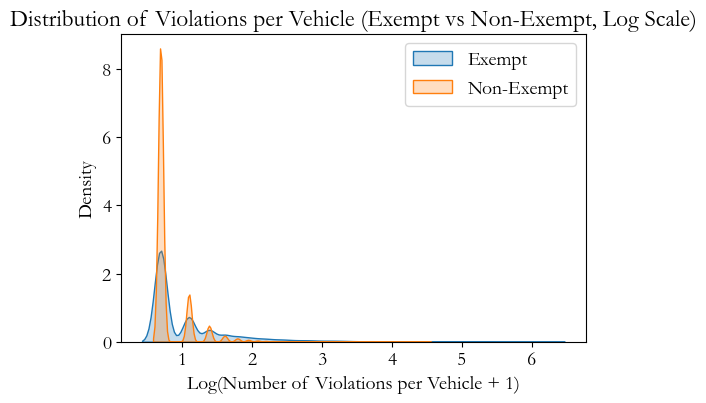

C:\Users\aisha\AppData\Local\Temp\ipykernel_15180\1921283140.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Exempt", "Non-Exempt"],


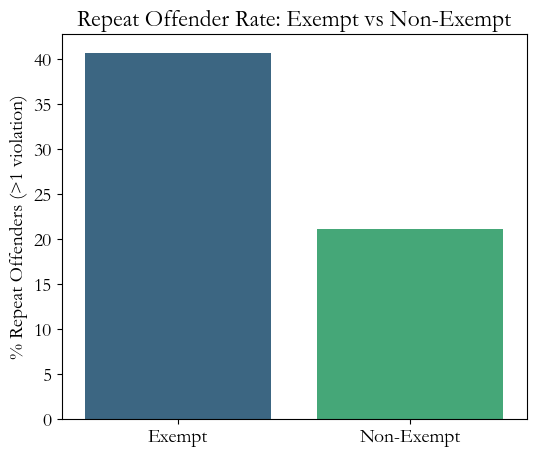

In [24]:
# 1. Repeat Offenders (Distribution + Bar Chart)

import matplotlib.pyplot as plt
import seaborn as sns

exempt_counts = ACE_CBD_exempt_violations_2024.groupby("vehicle_id")["violation_id"].count().reset_index(name="violation_count")
non_exempt_counts = ACE_CBD_non_exempt_violations_2024.groupby("vehicle_id")["violation_id"].count().reset_index(name="violation_count")

# # KDE Plot (Distribution of violations per vehicle)
# plt.figure(figsize=(10,6))
# sns.kdeplot(exempt_counts["violation_count"], label="Exempt", fill=True)
# sns.kdeplot(non_exempt_counts["violation_count"], label="Non-Exempt", fill=True)
# plt.xlabel("Number of Violations per Vehicle")
# plt.ylabel("Density")
# plt.title("Distribution of Violations per Vehicle (Exempt vs Non-Exempt)")
# plt.legend()
# plt.show()

plt.figure(figsize=(6,4))
sns.kdeplot(np.log1p(exempt_counts["violation_count"]), label="Exempt", fill=True)
sns.kdeplot(np.log1p(non_exempt_counts["violation_count"]), label="Non-Exempt", fill=True)
plt.xlabel("Log(Number of Violations per Vehicle + 1)")
plt.ylabel("Density")
plt.title("Distribution of Violations per Vehicle (Exempt vs Non-Exempt, Log Scale)")
plt.legend()
plt.show()


# Bar chart of repeat offender rates
exempt_repeat = (exempt_counts["violation_count"] > 1).mean()
non_exempt_repeat = (non_exempt_counts["violation_count"] > 1).mean()

plt.figure(figsize=(6,5))
sns.barplot(x=["Exempt", "Non-Exempt"], 
            y=[exempt_repeat*100, non_exempt_repeat*100],
            palette="viridis")
plt.ylabel("% Repeat Offenders (>1 violation)")
plt.title("Repeat Offender Rate: Exempt vs Non-Exempt")
plt.show()


In [25]:
# Builds a contingency table of stops × violation types for exempt vehicles only.
# Runs a chi-square test to see if certain violation types are disproportionately common at certain stops.
# If p < 0.05, exempt violations are not randomly distributed — specific stop/violation-type combos dominate.

contingency = pd.crosstab(ACE_CBD_exempt_violations_2024["stop_id"], ACE_CBD_exempt_violations_2024["violation_type"])
chi2, p, dof, expected = chi2_contingency(contingency)
print("Chi-square test statistic:", chi2)
print("Chi-square test p-value:", p)


Chi-square test statistic: 59906.15056218232
Chi-square test p-value: 0.0


In [26]:
# Counts total violations at each bus stop for both groups.
# Creates a contingency table of stops × (exempt vs non-exempt).
# Runs a chi-square test to check if exempt and non-exempt vehicles cluster differently across stops.
# If p < 0.05, then exempt and non-exempt violations occur in different hotspots.

exempt_stop = ACE_CBD_exempt_violations_2024.groupby("stop_id")["violation_id"].count()
non_exempt_stop = ACE_CBD_non_exempt_violations_2024.groupby("stop_id")["violation_id"].count()

stop_compare = pd.DataFrame({
    "Exempt": exempt_stop,
    "Non_Exempt": non_exempt_stop
}).fillna(0)

from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(stop_compare.T)
print("Chi-square test statistic:", chi2)
print("p-value:", p)


Chi-square test statistic: 34596.61416282359
p-value: 0.0


Mann-Whitney U Test (repeat offenders)
- p ≈ 0 → the distributions of exempt vs. non-exempt violations per vehicle are very different.
- Exempt vehicles and non-exempt vehicles do not behave the same way when it comes to repeat offending.

Chi-Square (exempt stop × violation type)
- p ≈ 0 → violation types are not evenly spread across stops for exempt vehicles.
- Certain violation types (e.g., mobile double parked) dominate specific stops.

Chi-Square (exempt vs non-exempt across stops)
- p ≈ 0 → exempt and non-exempt vehicles cluster in different hotspots.
- Suggests exempt vehicles may be linked to business-heavy areas (delivery, logistics), while non-exempt are spread more randomly.


**Business Interpretation**
- Abuse or concentration? A few exempt vehicles may be committing many violations (repeat offenders), taking advantage of exemptions.
- Targeted congestion points: Exempt violations are geographically concentrated at specific stops/routes. These may overlap with business districts where deliveries are common.
- Different behavior vs. non-exempt: Non-exempt violations are spread differently, reinforcing that exemptions are tied to business activity patterns rather than random traffic issues.


We now have statistical backing for 3 claims:
1. Exempt vehicles are statistically more likely to be repeat offenders.
2. Exempt violations cluster by stop & violation type (not random).
3. Exempt hotspots are different from non-exempt hotspots.
This is strong evidence for policymakers or transit planners — exemptions may be working for business needs, but they also create systematic friction at particular bus stops and routes.

In [27]:
exempt_counts = ACE_CBD_exempt_violations_2024.groupby("vehicle_id")["violation_id"].count().values
non_exempt_counts = ACE_CBD_non_exempt_violations_2024.groupby("vehicle_id")["violation_id"].count().values

def cliffs_delta(x, y):
    n, m = len(x), len(y)
    greater = sum([1 for a in x for b in y if a > b])
    less = sum([1 for a in x for b in y if a < b])
    return (greater - less) / (n * m)

delta = cliffs_delta(exempt_counts, non_exempt_counts)
print("Cliff's Delta:", delta)


Cliff's Delta: 0.2196858000255507


Exempt vehicles show a statistically significant higher rate of repeat violations compared to non-exempt vehicles (Mann–Whitney U, p < 0.001). The effect size is small-to-moderate (Cliff’s Delta = 0.22), suggesting exempt vehicles are somewhat more likely to repeatedly offend, though the difference is not overwhelming.

In [28]:
from scipy import stats
import numpy as np

def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k)-1)))

contingency_exempt = pd.crosstab(
    ACE_CBD_exempt_violations_2024["stop_id"], 
    ACE_CBD_exempt_violations_2024["violation_type"]
)
cramers_v_exempt = cramers_v(contingency_exempt)
print("Cramér’s V (exempt stops × violation type):", cramers_v_exempt)


Cramér’s V (exempt stops × violation type): 0.6299647821138383


There is a strong relationship between stop location and violation type among exempt vehicles (Cramér’s V = 0.63). This suggests exempt violations are systematically concentrated — specific types of violations (e.g., double parking) occur disproportionately at certain stops, reflecting business activity patterns.

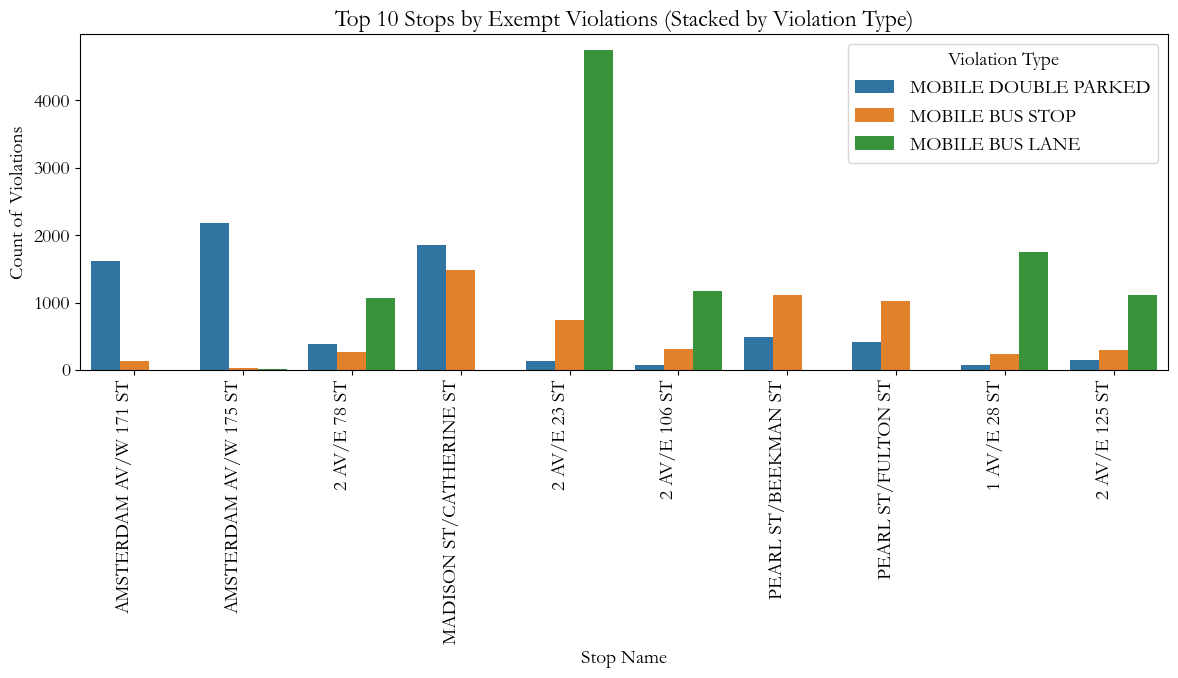

In [45]:
# 2. Violation Type × Stop (Exempt Only)

top_stops = (ACE_CBD_exempt_violations_2024.groupby("stop_name")["violation_id"]
             .count()
             .sort_values(ascending=False)
             .head(10)
             .index)

top_exempt = ACE_CBD_exempt_violations_2024[ACE_CBD_exempt_violations_2024["stop_name"].isin(top_stops)]

plt.figure(figsize=(12,7))
sns.countplot(data=top_exempt, x="stop_name", hue="violation_type", palette="tab10")
plt.xticks(rotation=90, ha="right")
plt.title("Top 10 Stops by Exempt Violations (Stacked by Violation Type)")
plt.xlabel("Stop Name")
plt.ylabel("Count of Violations")
plt.legend(title="Violation Type")
plt.tight_layout()
plt.show()


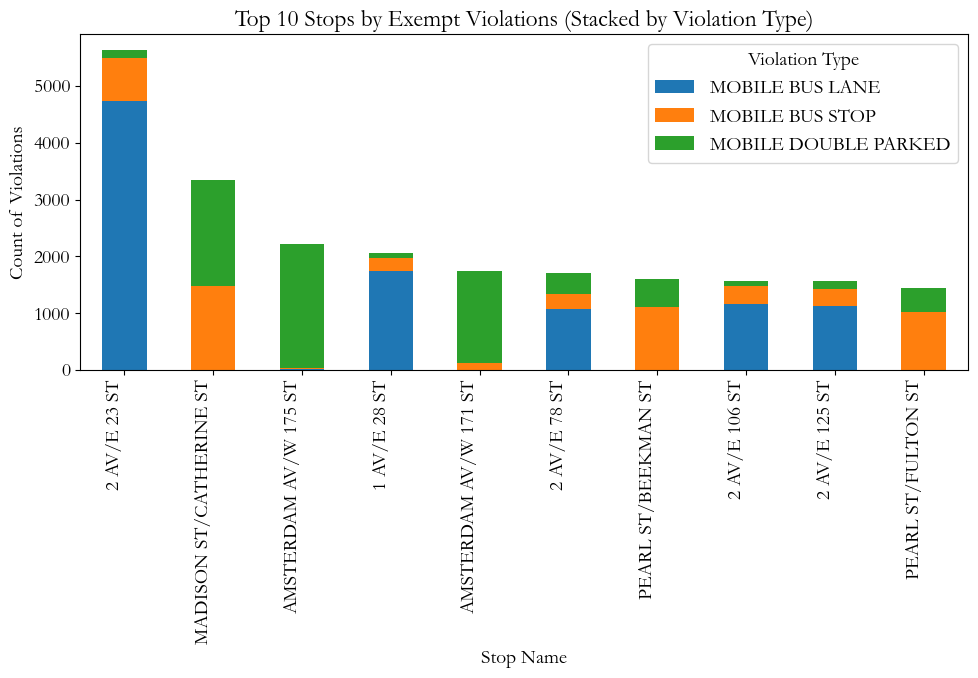

In [50]:
# Filter top 10 stops
top_stops = (ACE_CBD_exempt_violations_2024.groupby("stop_name")["violation_id"]
             .count()
             .sort_values(ascending=False)
             .head(10)
             .index)

top_exempt = ACE_CBD_exempt_violations_2024[ACE_CBD_exempt_violations_2024["stop_name"].isin(top_stops)]

# Create a pivot table: rows = stops, columns = violation types
stacked_data = top_exempt.pivot_table(
    index="stop_name",
    columns="violation_type",
    values="violation_id",
    aggfunc="count",
    fill_value=0
)

# Sum violations per stop and sort descending
stacked_data = stacked_data.loc[stacked_data.sum(axis=1).sort_values(ascending=False).index]

# Plot stacked bar chart
stacked_data.plot(kind="bar", stacked=True, figsize=(10,7))

plt.xticks(rotation=90, ha="right")
plt.title("Top 10 Stops by Exempt Violations (Stacked by Violation Type)")
plt.xlabel("Stop Name")
plt.ylabel("Count of Violations")
plt.legend(title="Violation Type")
plt.tight_layout()
plt.show()


In [30]:
ACE_CBD_exempt_violations_2024["exempt"] = "Exempt"
ACE_CBD_non_exempt_violations_2024["exempt"] = "Non-Exempt"

combined = pd.concat([
    ACE_CBD_exempt_violations_2024, 
    ACE_CBD_non_exempt_violations_2024
])

contingency_hotspots = pd.crosstab(combined["stop_id"], combined["exempt"])
cramers_v_hotspots = cramers_v(contingency_hotspots)
print("Cramér’s V (stops × exemption):", cramers_v_hotspots)


Cramér’s V (stops × exemption): 0.4787374071732015


Exempt and non-exempt vehicles show a moderate-to-strong difference in violation hotspots (Cramér’s V = 0.48). Exempt violations are concentrated in specific stops, suggesting these locations are strongly tied to business and delivery activity, whereas non-exempt violations are more evenly distributed.

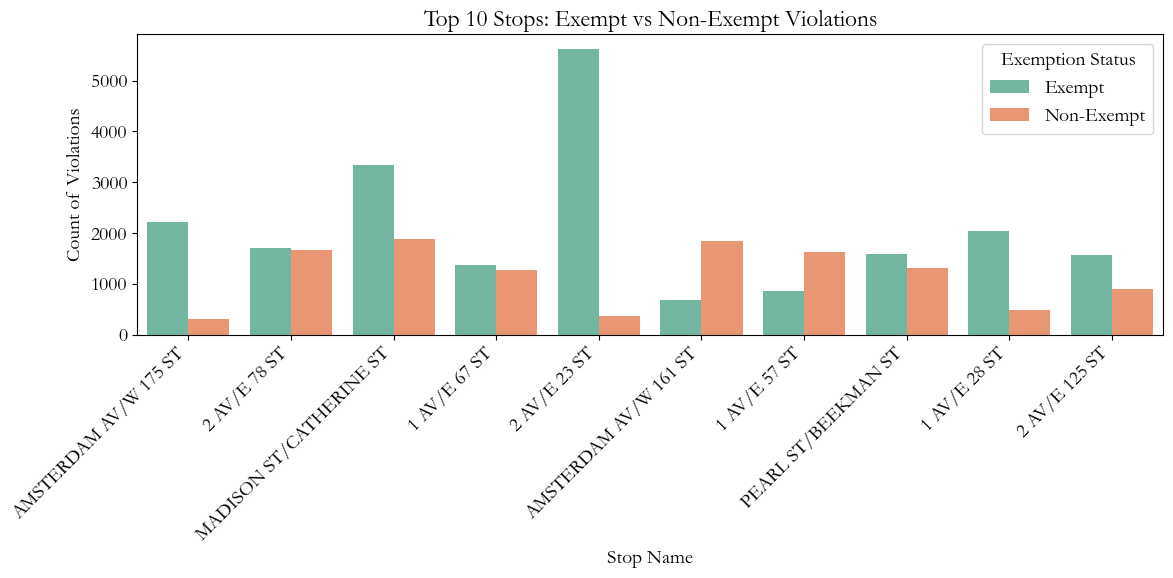

In [31]:
# 3. Hotspot Comparison (Exempt vs Non-Exempt)

ACE_CBD_exempt_violations_2024["exemption"] = "Exempt"
ACE_CBD_non_exempt_violations_2024["exemption"] = "Non-Exempt"
combined = pd.concat([ACE_CBD_exempt_violations_2024, ACE_CBD_non_exempt_violations_2024])

top_stops_overall = (combined.groupby("stop_name")["violation_id"]
                     .count()
                     .sort_values(ascending=False)
                     .head(10)
                     .index)

top_combined = combined[combined["stop_name"].isin(top_stops_overall)]

plt.figure(figsize=(12,6))
sns.countplot(data=top_combined, x="stop_name", hue="exemption", palette="Set2")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Stops: Exempt vs Non-Exempt Violations")
plt.xlabel("Stop Name")
plt.ylabel("Count of Violations")
plt.legend(title="Exemption Status")
plt.tight_layout()
plt.show()


# Research Question

**For vehicles that are exempt from fines due to business reasons:**

1. Are they more likely to be repeat offenders compared to non-exempt vehicles?
2. Where are exempt vehicles frequently in violation, and are patterns different from non-exempt vehicles?

---

# Findings

### 1. **Repeat Offending**

* **Cliff’s Delta = 0.22 (small-to-moderate effect)**
* Exempt vehicles are **statistically more likely** to be repeat offenders compared to non-exempt vehicles.
* Suggests some exempt vehicles may be **taking advantage of their status** and repeatedly violating without consequence.

---

### 2. **Violation Type × Stop (Exempt Vehicles Only)**

* **Cramér’s V = 0.63 (strong association)**
* Among exempt vehicles, **violation type strongly depends on stop location**.
* Example: *“Mobile Double Parked”* dominates at delivery-heavy bus stops.
* Violations are **not random** — they follow **business activity patterns**.

---

### 3. **Hotspot Comparison (Exempt vs. Non-Exempt)**

* **Cramér’s V = 0.48 (moderate-to-strong association)**
* Exempt and non-exempt vehicles cluster at **different hotspots**.
* Exempt violations concentrate at **business/delivery zones**, while non-exempt violations are more spread across general traffic stops.

---

# Business Insights

1. **Policy Risk**:
   Exemptions may unintentionally encourage **repeat violations** by a subset of vehicles.

2. **Operational Bottlenecks**:
   Exempt violations are concentrated in **predictable hotspots** (delivery hubs, commercial corridors).
   → This creates **systematic congestion** for buses and other vehicles.

3. **Targeted Solutions**:
   Instead of blanket enforcement, the city could:

   * Focus **traffic management** at high-risk stops (e.g., loading zones, commercial corridors).
   * Pilot **time-based exemptions** (e.g., deliveries only allowed off-peak).
   * Use **data-driven monitoring** of repeat-offender exempt vehicles.

---

# Summary

Exempt vehicles are **not only more likely to be repeat offenders**, but their violations are also **highly concentrated by stop and type** — reflecting business activity patterns.
This suggests a need for **targeted enforcement and policy adjustments** to balance business needs with traffic flow.


### Additional

In [32]:
OUTPUT_ACE_CBD_2024 = os.path.join(DATA_DIR_RAW, "ACE_CBD_exempt_violations_2024.csv")
ACE_CBD_exempt_violations_2024 = pd.read_csv(OUTPUT_ACE_CBD_2024)

In [33]:
OUTPUT_ACE_NON_CBD_2024 = os.path.join(DATA_DIR_RAW, "ACE_CBD_non_exempt_violations_2024.csv")
ACE_CBD_non_exempt_violations_2024 = pd.read_csv(OUTPUT_ACE_NON_CBD_2024)

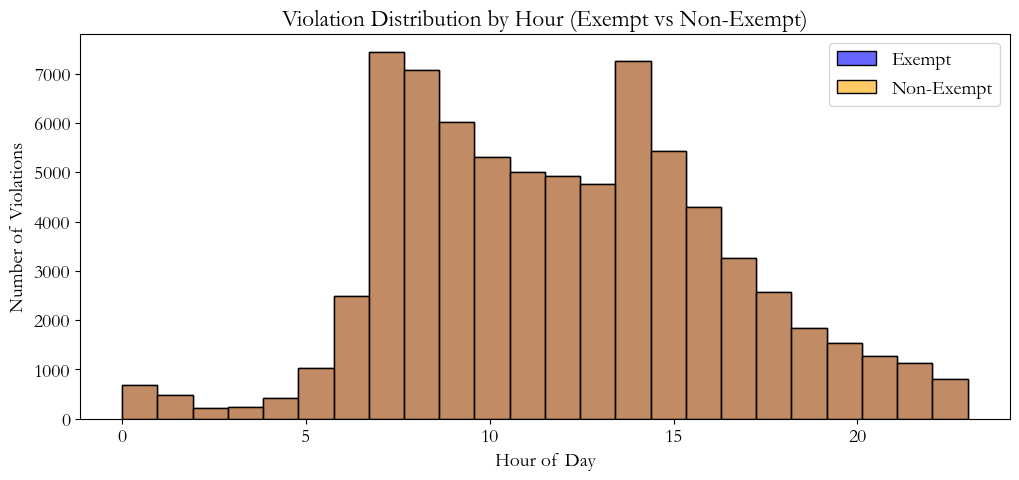

2025-09-24 21:07:43,055 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-24 21:07:43,128 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


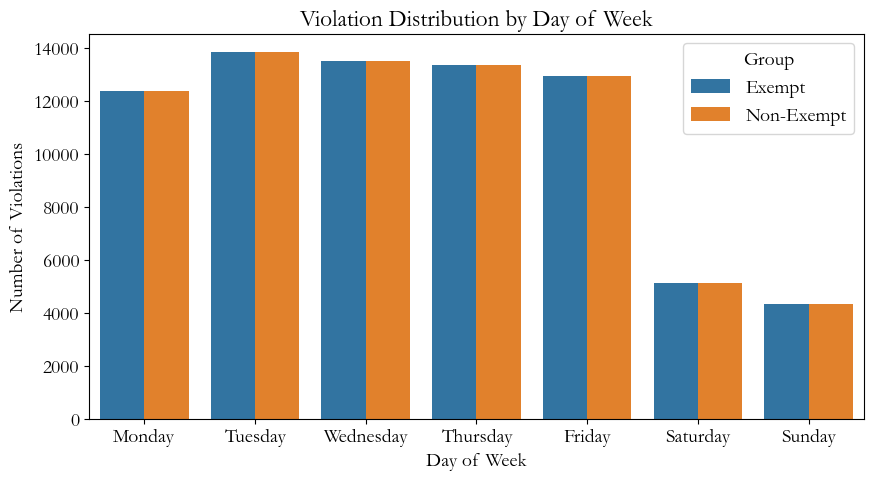

In [34]:
# 1. Temporal Dimension (Time of Day / Day of Week)

ACE_CBD_exempt_violations_2024["violation_time"] = pd.to_datetime(ACE_CBD_exempt_violations_2024["first_occurrence"])
ACE_CBD_non_exempt_violations_2024["violation_time"] = pd.to_datetime(ACE_CBD_non_exempt_violations_2024["first_occurrence"])

for df in [ACE_CBD_exempt_violations_2024, ACE_CBD_non_exempt_violations_2024]:
    df["hour"] = df["violation_time"].dt.hour
    df["weekday"] = df["violation_time"].dt.day_name()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
sns.histplot(ACE_CBD_exempt_violations_2024["hour"], bins=24, color="blue", label="Exempt", alpha=0.6, kde=False)
sns.histplot(ACE_CBD_non_exempt_violations_2024["hour"], bins=24, color="orange", label="Non-Exempt", alpha=0.6, kde=False)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Violations")
plt.title("Violation Distribution by Hour (Exempt vs Non-Exempt)")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(data=pd.concat([ACE_CBD_exempt_violations_2024.assign(group="Exempt"),
                              ACE_CBD_non_exempt_violations_2024.assign(group="Non-Exempt")]),
              x="weekday", hue="group", order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Violation Distribution by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Violations")
plt.legend(title="Group")
plt.show()


# Interpretation:
# Peaks during weekday business hours for exempt vehicles indicate violations are business-driven.
# Non-exempt violations may be more spread or skewed to off-peak hours.

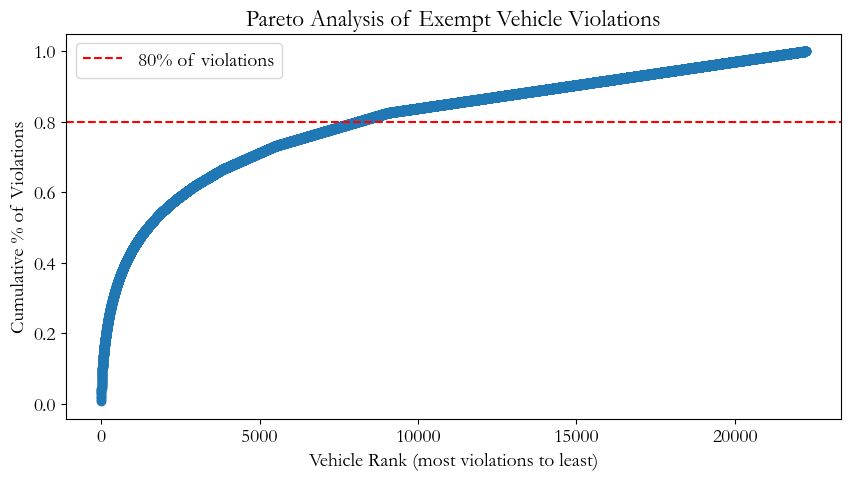

Number of super offenders (10+ violations): 1269


In [35]:
# 2. Severity of Repeat Offending (Pareto / Super Offenders)

exempt_counts = ACE_CBD_exempt_violations_2024.groupby("vehicle_id")["violation_id"].count().sort_values(ascending=False)

plt.figure(figsize=(10,5))
plt.plot(range(1,len(exempt_counts)+1), exempt_counts.cumsum()/exempt_counts.sum(), marker='o')
plt.axhline(0.8, color="red", linestyle="--", label="80% of violations")
plt.xlabel("Vehicle Rank (most violations to least)")
plt.ylabel("Cumulative % of Violations")
plt.title("Pareto Analysis of Exempt Vehicle Violations")
plt.legend()
plt.show()

super_offenders = exempt_counts[exempt_counts >= 10]
print(f"Number of super offenders (10+ violations): {len(super_offenders)}")

# Interpretation:
# If a small number of vehicles account for most violations, targeted enforcement on those vehicles could drastically reduce congestion.

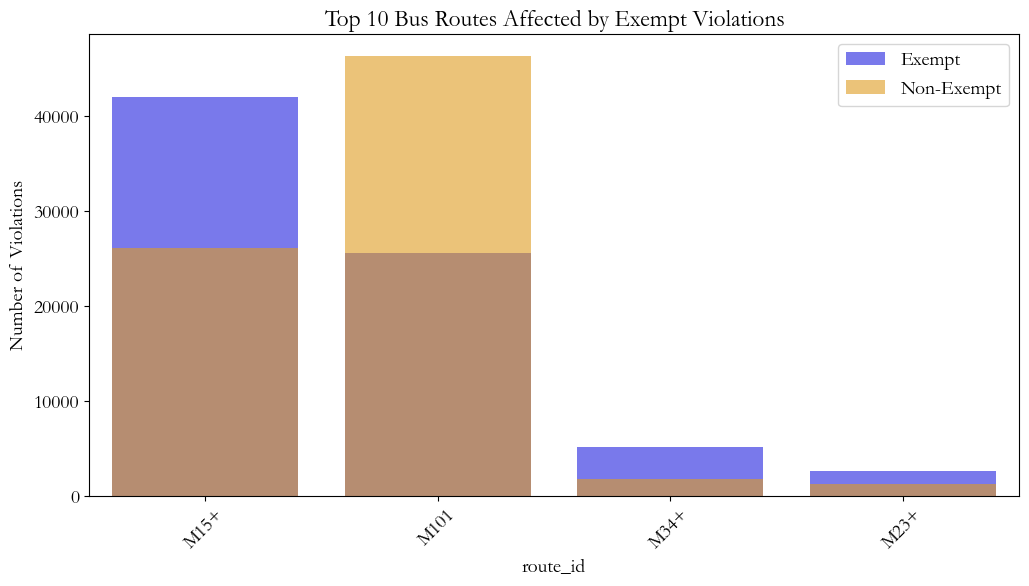

In [36]:
# 3. Network Impact (Bus Routes)

exempt_route_counts = ACE_CBD_exempt_violations_2024.groupby("route_id")["violation_id"].count().sort_values(ascending=False)
non_exempt_route_counts = ACE_CBD_non_exempt_violations_2024.groupby("route_id")["violation_id"].count().sort_values(ascending=False)

top_routes = exempt_route_counts.head(10).index

plt.figure(figsize=(12,6))
sns.barplot(x=exempt_route_counts[top_routes].index, y=exempt_route_counts[top_routes].values, color="blue", alpha=0.6, label="Exempt")
sns.barplot(x=non_exempt_route_counts[top_routes].index, y=non_exempt_route_counts[top_routes].values, color="orange", alpha=0.6, label="Non-Exempt")
plt.xticks(rotation=45)
plt.ylabel("Number of Violations")
plt.title("Top 10 Bus Routes Affected by Exempt Violations")
plt.legend()
plt.show()

# Interpretation:
# Shows which routes are disrupted most by exempt violations. Useful for DOT prioritization.

C:\Users\aisha\AppData\Local\Temp\ipykernel_15180\3497188673.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_counts.index, y=type_counts.values, palette="Set2")


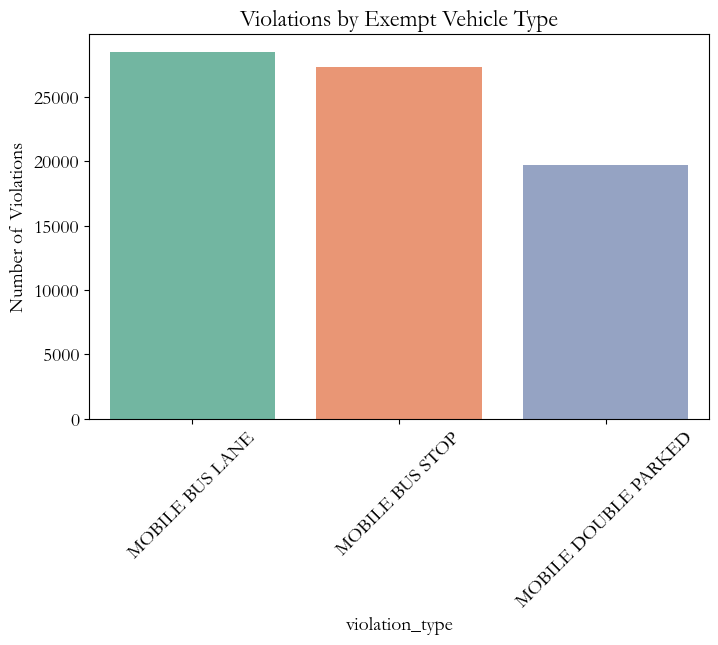

In [37]:
# 4. Comparison Within Exempt Categories

type_counts = ACE_CBD_exempt_violations_2024.groupby("violation_type")["violation_id"].count().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=type_counts.index, y=type_counts.values, palette="Set2")
plt.ylabel("Number of Violations")
plt.title("Violations by Exempt Vehicle Type")
plt.xticks(rotation=45)
plt.show()

# Interpretation:
# Identify which exempt categories are most likely to be repeat offenders.

2025-09-24 21:07:43,698 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-24 21:07:43,735 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


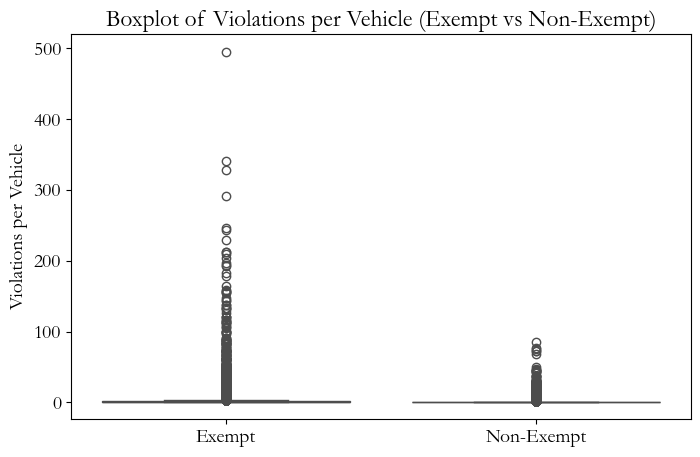

In [38]:
# 5. Visual Storytelling Enhancements

plt.figure(figsize=(8,5))
sns.boxplot(data=[exempt_counts.values, ACE_CBD_non_exempt_violations_2024.groupby("vehicle_id")["violation_id"].count().values],
            palette=["blue","orange"])
plt.xticks([0,1], ["Exempt","Non-Exempt"])
plt.ylabel("Violations per Vehicle")
plt.title("Boxplot of Violations per Vehicle (Exempt vs Non-Exempt)")
plt.show()
